# Mekong River Delta (Vietnam) study area


## S1 processing

* using SNAP and SNAP graph/processing pipeline
* standard steps: Apply precise orbit, thermal noise removal, remove GRD border noise, calibration, terrain correction (DEM: 30m Copernicus global) 10m pixel spacing, subset to region, linear to dB conversion
* calculation of RVI using `create-rvi-tif` python script (example run: `python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --scale log --polarizations VH VV "data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230808T224604_20230808T224629_049790_05FCD3_C933_Orb_NR_Cal_TC_dB.tif" "data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230808T224604_20230808T224629_049790_05FCD3_C933_Orb_NR_Cal_TC_dB_RVI.tif"`)

## SAOCOM processing
* using SNAP and SNAP graph/processing pipeline
* calculation of RVI using `create-rvi-tif` python script (example run: `python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --scale log --polarizations HH HV "data vietnam/data saocom vietnam/Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB_modified.tif" "data vietnam/data saocom vietnam/Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB_modified_RVI.tif"`)


## Cosmo SkyMed (CSK/CSG) processing
* using SNAP and SNAP graph/processing pipeline
* calculation of RVI using `create-rvi-tif` python script (example run: `python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --scale log --polarizations HH HV "data vietnam/data csk csg vietnam/Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230603225718_20230603225724_1_F_11N_Z48_N00.h5_ML_TC_dB.tif" "data vietnam/data csk csg vietnam/Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230603225718_20230603225724_1_F_11N_Z48_N00.h5_ML_TC_dB_RVI.tif"`)
* setting nodata value to 2 for RVI file (`gdal_edit.py -a_nodata 2 "data vietnam/data csk csg vietnam/Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230603225718_20230603225724_1_F_11N_Z48_N00.h5_ML_TC_dB_RVI.tif"`)


## NovaSAR processing

* SCD data provided by CSIRO
* Terrain correction using SNAP graph
* calibration to linear units using custom script `calibrate-novasar` (example: `python3 ~/dev/2023_multifrequency/2024-10-15-calibrate-novasar.py --input_file "./data vietnam/data novasar vietnam/NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2.tif" --output_file "./data vietnam/data novasar vietnam/NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear.tif" --bands 0 1`)
* RVI calculation (`python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --scale linear --polarizations HH HV "./data vietnam/data novasar vietnam/NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear.tif" "./data vietnam/data novasar vietnam/NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear-RVI.tif"`)

## Sentinel-2 processing/NDVI calculation

* using custom methods in each notebook
* masking using SCL layer

# Python imports

In [1]:
import geopandas as gpd
import pandas as pd
from datetime import date
from pathlib import Path
import numpy as np
import zipfile
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from tqdm import tqdm
import seaborn as sns

In [2]:
from multifrequtils import (
    scatterplot_nice, add_cr, compute_zonal_stats_rasterio_opened, get_filtered_pearsons_r,
    open_s2_and_save_ndvi_img, resample_20m_to_10m,
    read_s2_zip_scl,
)

In [3]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.min_rows", 4)

# Definitions

In [4]:
data_dir = Path("/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/")
vietnam_data_dir = data_dir / "data vietnam"

In [5]:
s2_img_dir = vietnam_data_dir / "data s2 vietnam"
s1_img_dir = vietnam_data_dir / "data s1 vietnam"
novasar_img_dir = vietnam_data_dir / "data novasar vietnam"
saocom_dir = vietnam_data_dir / "data saocom vietnam"
csg_csk_dir = vietnam_data_dir / "data csk csg vietnam"
vector_file_path = data_dir / 'fields-vietnam.geojson'

In [6]:
today_str = date.today().isoformat()
fig_out_dir = data_dir / f"{today_str}-figures-vietnam"
fig_out_dir.mkdir(exist_ok=True)

In [7]:
# to hold extracted data dictionaries
# dicts have this form: {"sensor": x, "polarization": x, "r": r, "N": x "p": x}
pearsonsr = list()

In [8]:
polygons = gpd.read_file(vector_file_path)
polygons

,polygon_id,geometry
0,0,"POLYGON ((105.69147 10.5059, 105.69139 10.5035..."
1,1,"POLYGON ((105.6905 10.50245, 105.69093 10.5028..."
...,...,...
206,206,"POLYGON ((105.77598 10.42576, 105.77626 10.425..."
207,207,"POLYGON ((105.74256 10.68712, 105.74199 10.685..."


# Polygon statistics

In [9]:
polygons_m = polygons.to_crs('epsg:32648')  # convert CRS to have unit meter
polygons["area_ha"] = polygons_m['geometry'].area / 10_000  # 10000m² =  1ha

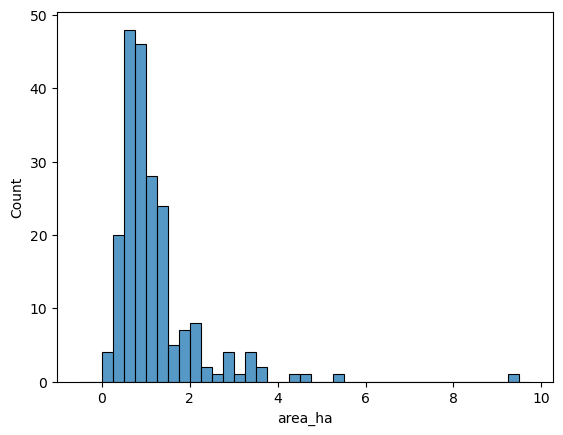

In [10]:
sns.histplot(data=polygons, x="area_ha", bins=np.arange(-0.5, 10, 0.25),)
plt.savefig(fig_out_dir / "polygon-size-ha.png")

In [11]:
polygons["area_ha"].quantile([0.85, 0.97])

0.85    1.878507
0.97    3.488328
Name: area_ha, dtype: float64

# Methods

## Zonal statistics methods

In [12]:
def compute_zonal_stats_rasterio(raster_path, polygons, raster_transformation_func=None, band_idx=0):
    with rasterio.open(raster_path) as src:
        stats_list = compute_zonal_stats_rasterio_opened(polygons=polygons, raster_ds=src, raster_transformation_func=raster_transformation_func, band_idx=band_idx)
    assert len(stats_list) >= 1, ("Couldn't retrieve statistics!", raster_path, len(polygons))
    count_before_size_filtering = len(stats_list)
    stats_list = [s for s in stats_list if s["count"] > 20] # is it??? # everything is at 10m pixel spacing or better, therefore, 0.5ha should be enough
    assert len(stats_list) >= 1, ("Didn't found big enouhg polygons!", raster_path, len(polygons))
    count_after_size_filtering = len(stats_list)
    print(f"Filtered {count_before_size_filtering - count_after_size_filtering} polygons.")
    return stats_list

## S2 NDVI creation methods

### mNDWI and other VIs tifs

In [13]:
def open_s2_zip_all_resolutions(s2_zip_path, 
                                bands, 
                                band_resolutions, 
                                cloud_mask_threshold: int = 60):
    band_arrays = list()
    profile = None

    assert all([b in {"10m", "20m"} for b in band_resolutions]), ("Only 10m and 20m bands supported so far", band_resolutions)
    highest_resolution = min(int(b[:2]) for b in band_resolutions)
    highest_resolution = f"{highest_resolution}m"

    with zipfile.ZipFile(s2_zip_path, 'r') as z:
        # extract raster band names
        band_paths = list()
        for band, band_resolution in zip(bands, band_resolutions):
            _band_paths = list(filter(lambda f: f'{band}_{band_resolution}.jp2' in f, z.namelist()))
            assert len(_band_paths) == 1, (f'{band}_{band_resolution}.jp2 not found in zip')
            band_paths.append((_band_paths[0], band_resolution))

        # Read the raster bands
        for band_path, band_resolution in band_paths:
            with z.open(band_path) as f:
                with MemoryFile(f.read()) as memfile:
                    with memfile.open() as src:
                        band_data = src.read(1)
                        #print(f"{band_path=}  {band_resolution=}  {highest_resolution=}")
                        if band_resolution == "20m" and highest_resolution == "10m":
                            band_data = resample_20m_to_10m(band_data, spline_order=1)  # linear interploation?
                        band_arrays.append(band_data)
                        
                        # Copy the profile for the first band and modify it for multi-band
                        if profile is None and band_resolution == highest_resolution:
                            profile = src.profile
    # modify the profile for multi-band
    profile.update(count=len(band_arrays), nodata=np.nan)
    
    # Create an in-memory multi-band raster dataset
    multi_band_array = np.stack(band_arrays)
    memfile = MemoryFile()
    with memfile.open(**profile) as dataset:
        dataset.write(multi_band_array)
    
    return memfile

In [14]:
def open_s2_and_save_normalized_difference_img(s2_zip_path, out_path, bands, band_resolutions):
    if out_path.is_file():
        print("Skipping existing tif.", out_path)
        return

    cloud_mask_threshold = 40
    scl_mask_values = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
    # No Data, Saturated or defective pixel, Topographic casted shadows, Cloud shadows, Cloud medium|high probability, cirrus, ice/snow
    s2_memfile = open_s2_zip_all_resolutions(s2_zip_path=s2_zip_path, bands=bands, band_resolutions=band_resolutions)
    with s2_memfile.open() as s2_zip:
        s2_raster = s2_zip.read().astype(np.float32)
        s2_raster_profile = s2_zip.profile
    assert s2_raster.shape[0] == len(bands)

    ### NDVI calculation
    s2_raster = np.clip(s2_raster, 1_000, 11_000) - 1000 # to have reflectance from 0-10k, clipping to avoid integer underflow
    ndvi_raster = (s2_raster[0] - s2_raster[1])/(s2_raster[0] + s2_raster[1] + 1e-9)
    ndvi_raster = np.clip(ndvi_raster, -1, 1)  # this should already be bound to this, but is not, so do it manually

    scl_raster = read_s2_zip_scl(s2_zip_path)
    if ndvi_raster.shape == (10980, 10980):  # 10m bands included
        scl_raster = resample_20m_to_10m(scl_raster)
    mask = (scl_raster == scl_mask_values[0])
    for scl_mask_value in scl_mask_values:
        mask |= (scl_raster == scl_mask_value)
    
    ndvi_masked = np.where(mask, np.nan, ndvi_raster)
    ndvi_masked = ndvi_masked.astype(np.float32)

    with rasterio.open(out_path, "w", driver='GTiff', 
                       height=s2_raster_profile["height"], 
                       width=s2_raster_profile["width"], 
                       dtype=ndvi_masked.dtype, 
                       crs=s2_raster_profile["crs"], 
                       transform=s2_raster_profile["transform"], 
                       count=1,
                       compress="PACKBITS",
                      ) as ndvi_ds:
        ndvi_ds.write(ndvi_masked, 1)

In [15]:
def open_s2_and_save_mndwi_img(s2_zip_path, ndvi_tif_dir):
    """Calculate MNDWI for S2 images: MNDWI = (B3 − B11)(B3 + B11)."""
    mndwi_tif_path = s2_zip_path.parent / (s2_zip_path.stem + "_mNDWI" + ".tif")
    bands = ['B03', 'B11']
    band_resolutions = ["10m", "20m"]
    open_s2_and_save_normalized_difference_img(s2_zip_path=s2_zip_path, 
                                               out_path=mndwi_tif_path, 
                                               bands=bands, band_resolutions=band_resolutions)

### Get zip paths and convert files

In [16]:
s2_zip_files = [
    s2_img_dir / "S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_20230808T073452.SAFE.zip",
    s2_img_dir / "S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_20230306T070117.SAFE.zip",
]

In [17]:
for s2_zip in tqdm(s2_zip_files):
    open_s2_and_save_ndvi_img(s2_zip_path=s2_zip, ndvi_tif_dir=s2_img_dir)
    open_s2_and_save_mndwi_img(s2_zip, ndvi_tif_dir=s2_img_dir)

100%|██████████| 2/2 [00:00<00:00, 4124.19it/s]

Skipping existing tif. /run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s2 vietnam/S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_20230808T073452.SAFE_NDVI.tif
Skipping existing tif. /run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s2 vietnam/S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_20230808T073452.SAFE_mNDWI.tif
Skipping existing tif. /run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s2 vietnam/S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_20230306T070117.SAFE_NDVI.tif
Skipping existing tif. /run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s2 vietnam/S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_20230306T070117.SAFE_mNDWI.tif


## Geocode NovaSAR files

In [18]:
def geocode_novasar_raster(novasar_raster, out_crs="EPSG:4326"):
    geocode_cmd_template = "gdalwarp -tps -r bilinear -srcnodata 0 -dstnodata 0 -t_srs {crs} '{src}' '{dst}'"
    geocoded_outpath = novasar_raster.parent / (novasar_raster.stem + "_wgs84.tif")#"_utm.tif")
    
    if geocoded_outpath.is_file():
        pass
        print(f"{Path(geocoded_outpath).parent} already geocoded. Skipping")
    else:
        geocode_cmd = geocode_cmd_template.format(crs=out_crs, src=str(novasar_raster), dst=str(geocoded_outpath))
        #print(f"Running '{geocode_cmd}'")
        #os.system(geocode_cmd)
        print(geocode_cmd)
    return geocoded_outpath

In [19]:
#novasar_raster_dirs = novasar_img_dir.glob("NovaSAR_01_*HH_HV")
#for novasar_raster_dir in novasar_raster_dirs:
#    novasar_raster_files = novasar_raster_dir.glob("image_??.tif")
#    for novasar_raster_file in novasar_raster_files:
#        geocode_novasar_raster(novasar_raster_file)

# Get raster file paths

### NovaSAR

In [20]:
novasar_raster_files = [
    novasar_img_dir / "NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear.tif",
    novasar_img_dir / "NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC2_modified-linear.tif"
]
novasar_rvi_files = [
    novasar_img_dir / "NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear-RVI.tif",
    novasar_img_dir / "NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC2_modified-linear-RVI.tif"
]
assert all([d.is_file() for d in (novasar_raster_files + novasar_rvi_files)])

### S-2 tifs

In [21]:
ndvi_files = list(s2_img_dir.glob("*_NDVI.tif"))
mndwi_files = list(s2_img_dir.glob("*_mNDWI.tif"))
len(set(ndvi_files)), len(set(mndwi_files))

(2, 2)

### Sentinel-1

In [22]:
def get_s1_snap_and_rvi_processed_files(s1_dir):
    # Subset_S1A_IW_GRDH_1SDV_20230305T224558_20230305T224623_047515_05B494_D765_Orb_NR_Cal_TC_dB
    db_rasters = list(s1_img_dir.glob("Subset_S1?_IW_GRDH_*_Orb_NR_Cal_TC_dB.tif"))
    rvi_rasters = list(s1_img_dir.glob("Subset_S1?_IW_GRDH_*_Orb_NR_Cal_TC_dB_RVI.tif"))
    return db_rasters, rvi_rasters

s1_raster_files, s1_rvi_files = get_s1_snap_and_rvi_processed_files(s1_dir=s1_img_dir)
s1_raster_files, s1_rvi_files

([PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230808T224604_20230808T224629_049790_05FCD3_C933_Orb_NR_Cal_TC_dB.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230306T111144_20230306T111209_047523_05B4DE_D2CD_Orb_NR_Cal_TC_dB.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230305T224558_20230305T224623_047515_05B494_D765_Orb_NR_Cal_TC_dB.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230809T111151_20230809T111216_049798_05FD1E_4CD0_Orb_NR_Cal_TC_dB.tif')],
 [PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data s1 vietnam/Subset_S1A_IW_GRDH_1SDV_20230808T224604_20230808T224629_049790_05FCD3_C933_Orb_NR_Cal_TC_dB_RVI.tif'),
  PosixPath('/run/media/t

### SAOCOM

In [23]:
# Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB
saocom_raster_files = list(saocom_dir.glob("Subset_S1*_Cal_ML_SRGR_TC_dB*_modified.tif"))
saocom_rvi_files = list(saocom_dir.glob("Subset_S1*_Cal_ML_SRGR_TC_dB*_modified_RVI.tif"))
saocom_raster_files, saocom_rvi_files

([PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data saocom vietnam/Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB_modified.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data saocom vietnam/Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230807T041747_Cal_ML_SRGR_TC_dB_modified.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data saocom vietnam/Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230305T114407_Cal_ML_SRGR_TC_dB_modified.tif')],
 [PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data saocom vietnam/Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB_modified_RVI.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data vietnam/data saocom vietnam/Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230807T041747_Cal_ML_SRGR_TC_dB_modified_RVI.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/

### CSG

In [24]:
csg_raster_files = [csg_csk_dir / "Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230806225718_20230806225725_1_F_11N_Z48_N00.h5_ML_TC_dB.tif"]
csg_rvi_raster_files = [csg_csk_dir / "Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230806225718_20230806225725_1_F_11N_Z48_N00.h5_ML_TC_dB_RVI.tif"]

# Get statistiscs

### Sentinel-2

In [25]:
novasar_s2_date_mapping = {
    # novasar_date: s2_date
    '20230305': "20230306",
    "20230806": "20230808", 
}

In [26]:
s2_vi_filter_func = lambda p: any((date in p.stem) for date in novasar_s2_date_mapping.values())
ndvi_files = list(filter(s2_vi_filter_func, ndvi_files))
mndwi_files = list(filter(s2_vi_filter_func, mndwi_files))

In [27]:
def get_s2_statistics(s2_ndvi_files, s2_mndwi_files, polygons):
    stats = list()
    
    for ndvi_file, mndwi_file in tqdm(zip(s2_ndvi_files, s2_mndwi_files)):
        stats_ndvi = compute_zonal_stats_rasterio(polygons=polygons, raster_path=ndvi_file)
        stats_mndwi = compute_zonal_stats_rasterio(polygons=polygons, raster_path=mndwi_file)
            
        for d_ndvi, d_mndwi in zip(stats_ndvi, stats_mndwi):
            assert d_ndvi["polygon_id"] == d_mndwi["polygon_id"]
            d_ndvi["filename"] = ndvi_file.stem
            d_ndvi["mndwi_mean"] = d_mndwi["mean"]
            stats.append(d_ndvi)   
    stats_df = pd.DataFrame(stats)
    return stats_df

In [28]:
stats_s2_df = get_s2_statistics(s2_ndvi_files=ndvi_files, s2_mndwi_files=mndwi_files, polygons=polygons)
_s2_dates = stats_s2_df.loc[:, "filename"].map(lambda f: f.split("_")[2].split("T")[0]).copy()
stats_s2_df.loc[:, "date"] = _s2_dates
stats_s2_df = stats_s2_df.merge(polygons, on="polygon_id")
stats_s2_df = stats_s2_df[stats_s2_df.mndwi_mean <= 0.2]
len(stats_s2_df)

0it [00:00, ?it/s]

Filtered 38 polygons.


1it [00:00,  1.10it/s]

Filtered 38 polygons.
Filtered 31 polygons.


2it [00:01,  1.16it/s]

Filtered 31 polygons.


330

In [29]:
stats_s2_df

,mean,median,count,polygon_id,filename,mndwi_mean,date,geometry,area_ha
0,0.790918,0.784024,141,0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.541031,20230808,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
1,0.878247,0.897676,525,1,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581761,20230808,"POLYGON ((105.6905 10.50245, 105.69093 10.5028...",5.264936
...,...,...,...,...,...,...,...,...,...
345,0.085437,0.087558,74,204,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.196658,20230306,"POLYGON ((105.69794 10.50174, 105.69796 10.501...",0.740695
346,0.942341,0.943733,84,207,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.585609,20230306,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021


### NovaSAR

In [30]:
def read_inc_angle(metadata_filepath):
    # <IncAngleCoeffs>27.075 0.00085775 -5.5288E-09 -2.2216E-14 -7.7528E-18 2.6808E-21 </IncAngleCoeffs>
    with open(metadata_filepath, "r") as fd:
        lines = fd.readlines()
        angle_line = list(filter(lambda l: "IncAngleCoeffs" in l, lines))
        assert len(angle_line) == 1
        angle_line = angle_line[0].strip()  # remove whitespace
        inc_angle = angle_line.split(">")[1].split(" ")[0]
    inc_angle = float(inc_angle)
    return inc_angle

In [31]:
def novasar_raster_to_logscale(calibrated: np.ma.masked_array):
    assert type(calibrated) == np.ma.core.MaskedArray, ("Type error.", type(calibrated))
    
    db_data = np.ones_like(calibrated)
    valid_mask = (calibrated > 0)                # negative values/zero are invalid for log10
    db_data[valid_mask] = calibrated[valid_mask] # copy usable values
    assert np.all(db_data.data > 0)
    
    db_data = 10 * np.log10(db_data)
    db_data = np.ma.masked_equal(db_data, 0)
    db_data.mask |= (calibrated == 0)
    assert type(db_data) == np.ma.core.MaskedArray, ("Type error.", type(db_data))

    return db_data

In [32]:
def get_poylgon_stats_novasar(novasar_raster_files, polygons, raster_transformation_func=None):
    stats_novasar = list()
    for novasar_raster_file, rvi_file in tqdm(zip(novasar_raster_files, novasar_rvi_files)):
        
        stats_hh = compute_zonal_stats_rasterio(raster_path=novasar_raster_file, polygons=polygons, raster_transformation_func=raster_transformation_func, band_idx=0)
        stats_hv = compute_zonal_stats_rasterio(raster_path=novasar_raster_file, polygons=polygons, raster_transformation_func=raster_transformation_func, band_idx=1)
        stats_lia = compute_zonal_stats_rasterio(raster_path=novasar_raster_file, polygons=polygons, band_idx=2)

        stats_rvi = compute_zonal_stats_rasterio(raster_path=novasar_raster_file, polygons=polygons, band_idx=1)

        for stats_pol, pol in [(stats_hh, "HH"), (stats_hv, "HV"), (stats_rvi, "RVI")]:
            for d, lia in zip(stats_pol, stats_lia):
                d["filename"] = novasar_raster_file.stem
                d["polarization"] = pol
                d["incidence_angle"] = lia["mean"]
            stats_novasar.extend(stats_pol)
    stats_novasar = pd.DataFrame(stats_novasar)
    return stats_novasar

In [33]:
stats_novasar_df = get_poylgon_stats_novasar(novasar_raster_files=novasar_raster_files, 
                                             polygons=polygons, 
                                             raster_transformation_func=novasar_raster_to_logscale)

0it [00:00, ?it/s]

Filtered 3 polygons.
Filtered 3 polygons.
Filtered 3 polygons.


1it [00:03,  3.90s/it]

Filtered 3 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.


2it [00:06,  3.03s/it]

Filtered 2 polygons.


In [34]:
filename_date_mapping = {
    "NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC2-linear": "20230305",
    "NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC2_modified-linear": "20230806",
}

In [35]:
stats_novasar_df.loc[:, "date"] = stats_novasar_df.loc[:, "filename"].map(lambda f: filename_date_mapping[f]).copy()

In [36]:
stats_novasar_df =  add_cr(data=stats_novasar_df, x="median", cross_pol="HV", co_pol="HH", date_col="date", cr_col="CR")

In [37]:
_s2_date_of_novasar_img = stats_novasar_df.loc[:, "date"].map(lambda d: novasar_s2_date_mapping[d]).copy()
stats_novasar_df.loc[:, "s2_date"] = _s2_date_of_novasar_img
stats_novasar_df = stats_novasar_df[stats_novasar_df.loc[:, "s2_date"] != ""]
stats_novasar_df

,mean,median,count,polygon_id,filename,polarization,incidence_angle,date,s2_date
0,-11.598124,-11.712430,146,0,NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC...,HH,26.812330,20230305,20230306
1,-11.122495,-11.361815,534,1,NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC...,HH,26.806000,20230305,20230306
...,...,...,...,...,...,...,...,...,...
1642,-2.307953,9.956653,86,207,NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC...,CR,25.963827,20230305,20230306
1643,-0.292014,11.871347,87,207,NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC...,CR,13.560713,20230806,20230808


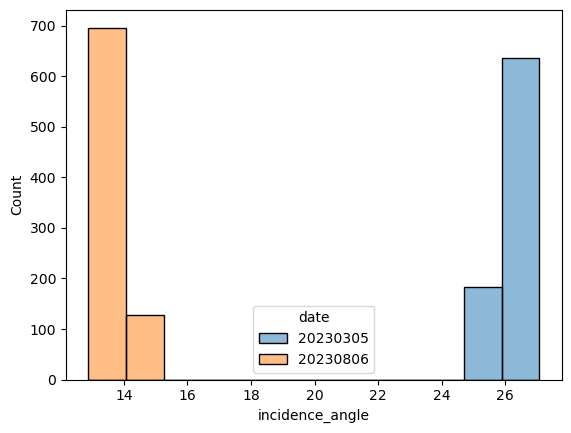

In [38]:
sns.histplot(data=stats_novasar_df, x="incidence_angle", hue="date")
plt.savefig(fig_out_dir / "novasar-incidence_angle.png")

#### Data distribution plots

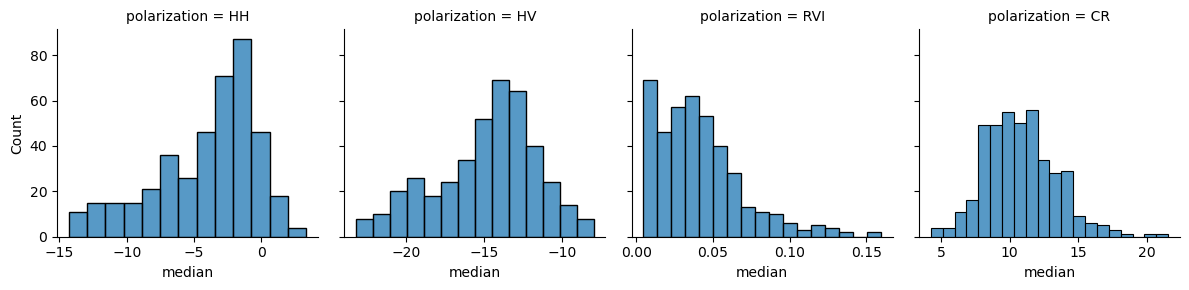

In [39]:
g = sns.FacetGrid(data=stats_novasar_df, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")
plt.savefig(fig_out_dir / f"novasar-distribution-alldatatypes.png")

### S1 statistics

In [40]:
s1_s2_date_mapping = {
    # s1_date : s2_date
    "20230305": "20230306", 
    "20230306": "20230306",
    "20230808": "20230808",
    "20230809": "20230808",
}
s1_orbit_mapping = {
    # s1 date : orbit
    "20230305": "DESCENDING", 
    "20230306": "ASCENDING",
    "20230808": "DESCENDING",
    "20230809": "ASCENDING",
    "20230621": "???",
    "20230116": "???",

}

In [41]:
def get_s1_statistcs_dataframe(s1_rasters, s1_rvi_rasters, polygons):
    stats = list()
    for s1_raster, s1_rvi_raster in zip(s1_rasters, s1_rvi_rasters):
        _stats_vh = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=0)
        _stats_vv = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=1)
        _stats_lia = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=3)
        _stats_rvi = compute_zonal_stats_rasterio(raster_path=s1_rvi_raster, polygons=polygons, band_idx=0)
        
        for _stats, pol in zip([_stats_vv, _stats_vh, _stats_rvi], ["VV", "VH", "RVI"]):
            for d, lia in zip(_stats, _stats_lia):
                d["filename"] = s1_raster.stem
                d["polarization"] = pol
                d["local_incidence_angle"] = lia["mean"]
            stats.extend(_stats)

    stats = pd.DataFrame(stats)
    return stats

def s1_add_date_using_filename(s1_df):
    # Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_VH.tif
    date_func = lambda f: f.split("_")[5].split("T")[0]
    s1_dates = s1_df.loc[:, "filename"].map(date_func).copy()
    s1_df.loc[:, "date"] = s1_dates
    return s1_df

In [42]:
s1_filter_func = lambda p: any((date in p.stem) for date in s1_s2_date_mapping.keys())
s1_raster_files = list(filter(s1_filter_func, s1_raster_files))

In [43]:
stats_s1 = get_s1_statistcs_dataframe(s1_rasters=s1_raster_files, s1_rvi_rasters=s1_rvi_files, polygons=polygons)
stats_s1 = s1_add_date_using_filename(stats_s1)
stats_s1 =  add_cr(data=stats_s1, x="median", cross_pol="VH", co_pol="VV", date_col="date", cr_col="CR")

Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 3 polygons.
Filtered 3 polygons.
Filtered 3 polygons.
Filtered 3 polygons.


#### Data distribution plotsm

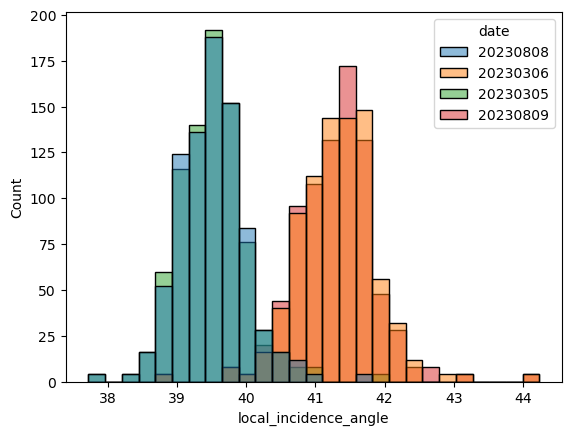

In [44]:
sns.histplot(data=stats_s1, x="local_incidence_angle", hue="date")
plt.savefig(fig_out_dir / "s1-incidence_angle.png")

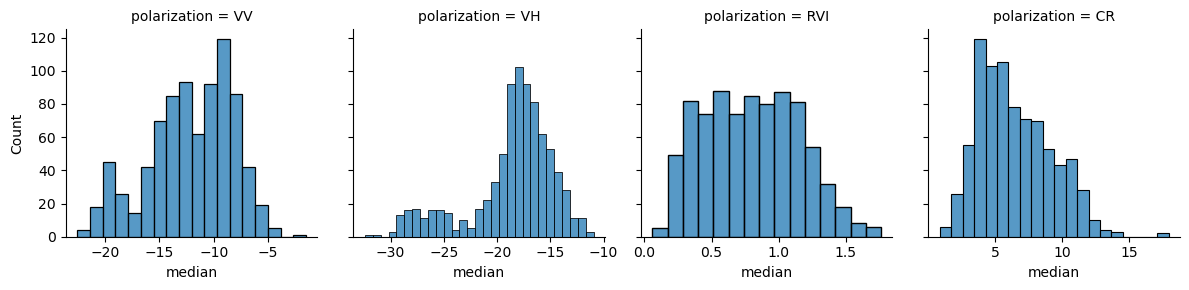

In [45]:
g = sns.FacetGrid(data=stats_s1, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")
plt.savefig(fig_out_dir / f"s1-distribution-alldatatypes.png")

### SAOCOM

In [46]:
def get_saocom_statistcs_dataframe(saocom_rasters, saocom_rvi_rasters, polygons):
    stats = list()
    for sao_raster, sao_rvi in tqdm(zip(saocom_rasters, saocom_rvi_rasters)):
        # TODO check if the band_idx - polarization mapping is correct
        _stats_hh = compute_zonal_stats_rasterio(raster_path=sao_raster, polygons=polygons, band_idx=0)
        _stats_hv = compute_zonal_stats_rasterio(raster_path=sao_raster, polygons=polygons, band_idx=1)
        _stats_lia = compute_zonal_stats_rasterio(raster_path=sao_raster, polygons=polygons, band_idx=2)
        _stats_rvi = compute_zonal_stats_rasterio(raster_path=sao_rvi, polygons=polygons, band_idx=0)

        for _stats, pol in zip([_stats_hh, _stats_hv, _stats_rvi], ["HH", "HV", "RVI"]):
            for d, lia in zip(_stats, _stats_lia):
                d["filename"] = sao_raster.stem
                d["polarization"] = pol
                d["local_incidence_angle"] = lia["mean"]
            stats.extend(_stats)
    
    stats = pd.DataFrame(stats)
    return stats

stats_saocom = get_saocom_statistcs_dataframe(saocom_rasters=saocom_raster_files, saocom_rvi_rasters=saocom_rvi_files, polygons=polygons)

0it [00:00, ?it/s]

Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.


1it [00:01,  1.80s/it]

Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.


2it [00:03,  1.79s/it]

Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.
Filtered 2 polygons.


3it [00:05,  1.79s/it]

Filtered 2 polygons.


In [47]:
# for SAOCOM, the filename contains only the processing date (?), not the acquision date.
# the acquisition date is only in the metadata, visible in SNAP
# therefore, we have to add this mapping manually
saocom_filepath_date_mapping = {
    "Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230305T114407_Cal_ML_SRGR_TC_dB": "20230303", 
    "Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB": "20230306", 
    "Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230807T041747_Cal_ML_SRGR_TC_dB": "20230805", 
    "Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230807T041747_Cal_ML_SRGR_TC_dB_modified": "20230805",
    "Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_20230309T204419_Cal_ML_SRGR_TC_dB_modified": "20230306",
    "Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_20230305T114407_Cal_ML_SRGR_TC_dB_modified": "20230303",    
}

In [48]:
stats_saocom["date"] = stats_saocom.filename.map(lambda f: saocom_filepath_date_mapping[f]).copy()

<Axes: xlabel='median', ylabel='Count'>

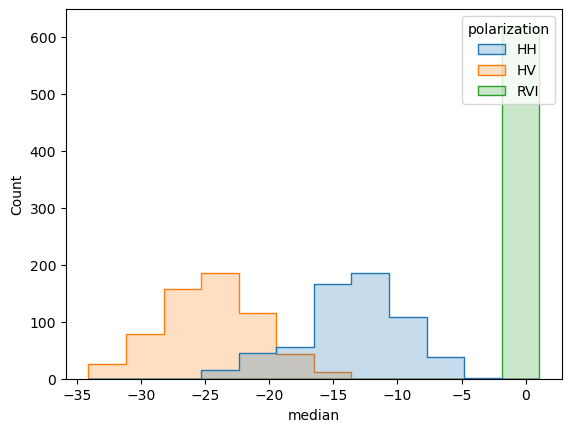

In [49]:
sns.histplot(data=stats_saocom, x="median", hue="polarization", element="step")

In [50]:
stats_saocom = add_cr(data=stats_saocom, x="median", cross_pol="HV", co_pol="HH", date_col="date", cr_col="CR")
stats_saocom["local_incidence_angle"] = 10**(stats_saocom["local_incidence_angle"]/10)  # because of wrong processing, this is in dB and needs to be converted back

#### Data distributions plots

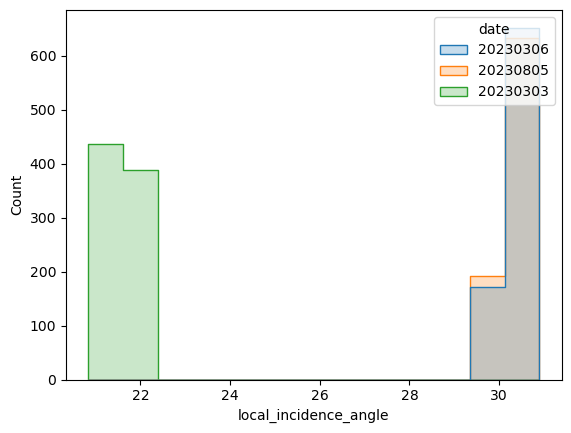

In [51]:
sns.histplot(data=stats_saocom, x="local_incidence_angle", hue="date", element="step")
plt.savefig(fig_out_dir / "saocom-incidence_angle.png")

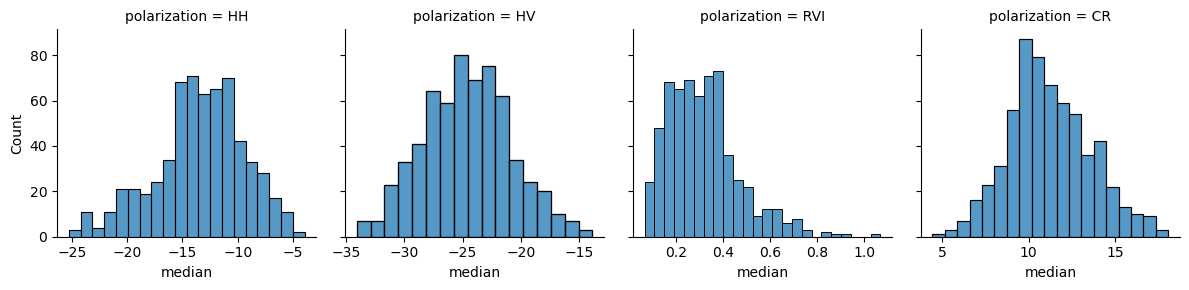

In [52]:
g = sns.FacetGrid(data=stats_saocom, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")
plt.savefig(fig_out_dir / f"saocom-distribution-alldatatypes.png")

### CSG 

In [53]:
def get_csg_statistcs_dataframe(csg_rasters, csg_rvi_rasters, polygons):
    stats = list()
    for csg_raster, csg_rvi_raster in tqdm(zip(csg_rasters, csg_rvi_rasters), 
                                           total=len(csg_rasters)):
        
        _stats_hh = compute_zonal_stats_rasterio(raster_path=csg_raster, polygons=polygons, band_idx=0)
        _stats_hv = compute_zonal_stats_rasterio(raster_path=csg_raster, polygons=polygons, band_idx=1)
        _stats_lia = compute_zonal_stats_rasterio(raster_path=csg_raster, polygons=polygons, band_idx=2)
        _stats_rvi = compute_zonal_stats_rasterio(raster_path=csg_rvi_raster, polygons=polygons, band_idx=0)
        pol_stats = {"HH": _stats_hh, "HV": _stats_hv, "RVI": _stats_rvi}
        for pol, _stats in pol_stats.items():
            for d, lia in zip(_stats, _stats_lia):
                d["filename"] = csg_raster.stem
                d["polarization"] = pol
                d["local_incidence_angle"] = lia["mean"]
            stats.extend(_stats)

    stats = pd.DataFrame(stats)
    return stats

def add_csg_date_using_filename(df):
    # Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230806225718_20230806225725_1_F_11N_Z48_N00.h5_ML_TC_dB.tif.vrt
    date_func = lambda f: f.split("_")[9][:8]
    dates = df.loc[:, "filename"].map(date_func).copy()
    df.loc[:, "date"] = dates
    return df

stats_csg = get_csg_statistcs_dataframe(csg_rasters=csg_raster_files, csg_rvi_rasters=csg_rvi_raster_files, polygons=polygons)
stats_csg

  0%|          | 0/1 [00:00<?, ?it/s]

Filtered 10 polygons.
Filtered 10 polygons.
Filtered 10 polygons.


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

Filtered 10 polygons.


,mean,median,count,polygon_id,filename,polarization,local_incidence_angle
0,-10.209681,-10.204177,996,0,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,HH,16.525202
1,-9.825768,-9.801847,3752,1,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,HH,16.525661
...,...,...,...,...,...,...,...
592,0.555706,0.501401,444,206,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,RVI,16.566324
593,1.258777,1.171140,602,207,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,RVI,16.576687


In [54]:
csg_filename_date_mapping = {
    "Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_RA_R_20230806225718_20230806225725_1_F_11N_Z48_N00.h5_ML_TC_dB": "20230806",
}
stats_csg["date"] = stats_csg.filename.map(lambda f: csg_filename_date_mapping[f]).copy()

In [55]:
stats_csg = add_cr(data=stats_csg, x="median", cross_pol="HV", co_pol="HH", date_col="date", cr_col="CR")
stats_csg["local_incidence_angle"] = 10**(stats_csg["local_incidence_angle"]/10)  # because of wrong processing, this is in dB and needs to be converted back

#### data distribution pltos

<Axes: xlabel='median', ylabel='Count'>

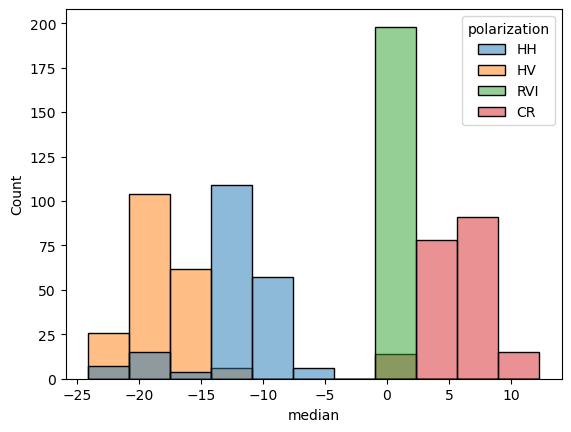

In [56]:
sns.histplot(data=stats_csg, x="median", hue="polarization")

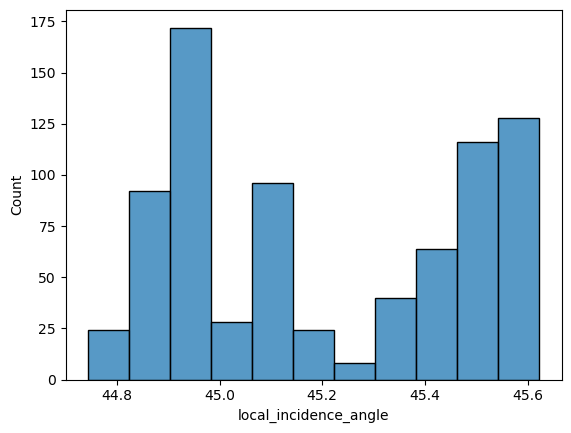

In [57]:
sns.histplot(data=stats_csg, x="local_incidence_angle")
plt.savefig(fig_out_dir / "csg-incidence_angle.png")

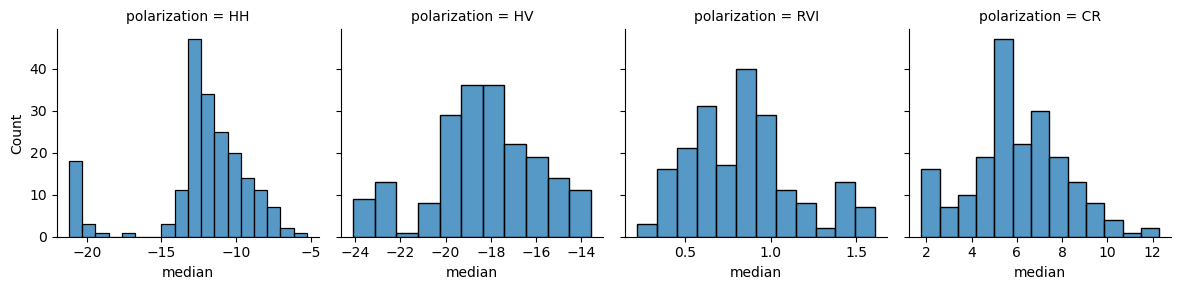

In [58]:
g = sns.FacetGrid(data=stats_csg, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median")
plt.savefig(fig_out_dir / f"csg-distribution-alldatatypes.png")

# Filter and combine stats

# Visualisierung

In [59]:
sns.set_theme(style="whitegrid")
ylim = (-0.1, 1)

## NovaSAR

In [60]:
print("sar:", list(sorted(stats_novasar_df.date.unique().tolist())))
print(" s2:", list(sorted(stats_s2_df.date.unique())))

sar: ['20230305', '20230806']
 s2: ['20230306', '20230808']


In [61]:
sensor = "NovaSAR"

In [62]:
joined_novasar = stats_novasar_df.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_novasar', '_s2'))
joined_novasar = joined_novasar[~pd.isnull(joined_novasar.s2_date)]
joined_novasar = joined_novasar[~pd.isnull(joined_novasar.median_s2)]
joined_novasar

,mean_novasar,median_novasar,count_novasar,polygon_id,filename_novasar,polarization,incidence_angle,date_novasar,s2_date,mean_s2,median_s2,count_s2,filename_s2,mndwi_mean,date_s2,geometry,area_ha
0,-11.598124,-11.712430,146.0,0,NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC...,HH,26.812330,20230305,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
1,-19.610790,-19.609821,146.0,0,NovaSAR_01_42627_scd_32_230305_030519_HH_HV_TC...,HV,26.812330,20230305,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,0.067831,0.062094,87.0,207,NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC...,RVI,13.560713,20230806,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021
1644,-0.292014,11.871347,87.0,207,NovaSAR_01_46818_scd_32_230806_152509_HH_HV_TC...,CR,13.560713,20230806,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021


In [63]:
joined_novasar.to_csv(fig_out_dir / "novasar-s2-statistics.csv")

In [64]:
list(sorted(joined_novasar.date_novasar.unique())), list(sorted(joined_novasar.polarization.unique()))

(['20230305', '20230806'], ['CR', 'HH', 'HV', 'RVI'])

In [65]:
_joined = joined_novasar.copy()
datanames = ["HV", "HH", "CR", "RVI"]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]
xlims = [(-30, -7), (-20, 7), (3, None), (0, None)]

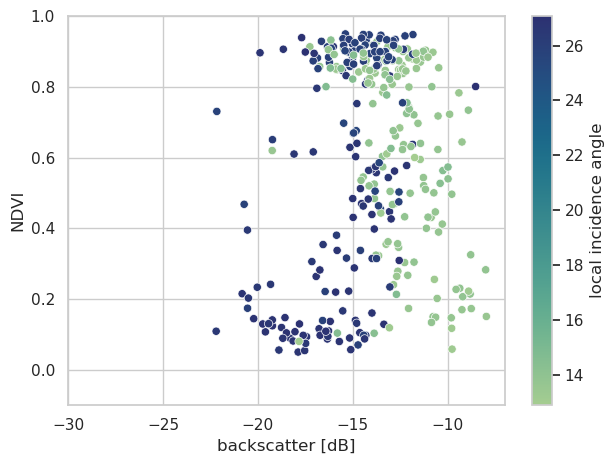

Filtered water pixels away
High p value! 0.009


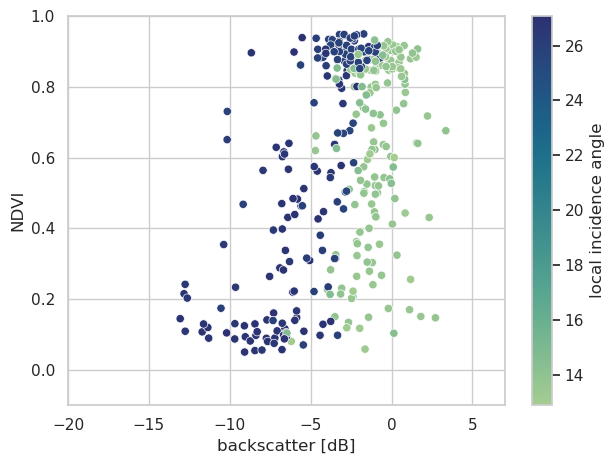

Filtered water pixels away


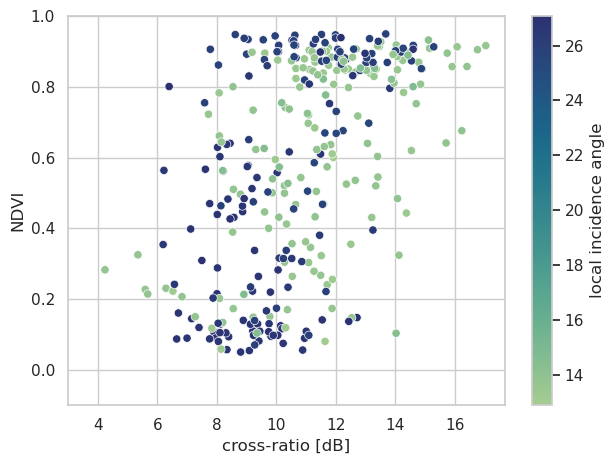

Filtered water pixels away


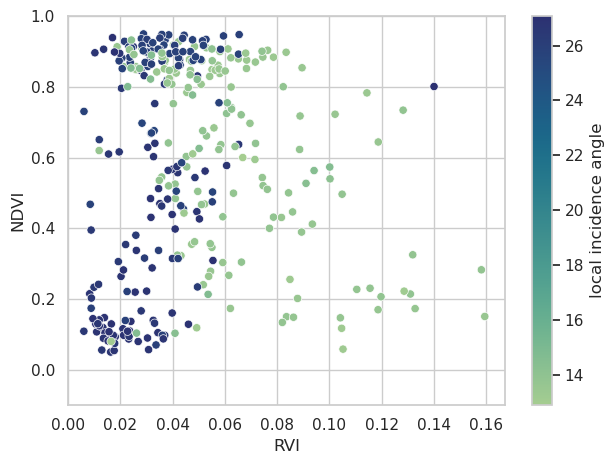

Filtered water pixels away
High p value! 0.820


In [66]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    scatterplot_nice(x="median_novasar", y="median_s2", data=joined_pol,
                     hue="incidence_angle",
                     xlabel=xlabel, ylabel="NDVI", huelabel="local incidence angle",
                     xlim=xlim,
                     ylim=ylim,
                    )
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_novasar", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

In [67]:
_joined = joined_novasar.copy()
ndvi_threshold = 0.25

In [68]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    joined_pol = joined_pol[joined_pol.median_s2 < ndvi_threshold]

    dataname += f" NDVI<{ndvi_threshold}"
    pearsonsr_pol = get_filtered_pearsons_r(x="median_novasar", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

Filtered water pixels away
High p value! 0.004
Filtered water pixels away
High p value! 0.006
Filtered water pixels away
High p value! 0.977
Filtered water pixels away
High p value! 0.001


In [69]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    joined_pol = joined_pol[joined_pol.median_s2 > ndvi_threshold]

    dataname += f" NDVI>{ndvi_threshold}"
    pearsonsr_pol = get_filtered_pearsons_r(x="median_novasar", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

Filtered water pixels away
High p value! 0.002
Filtered water pixels away
Filtered water pixels away
Filtered water pixels away
High p value! 0.002


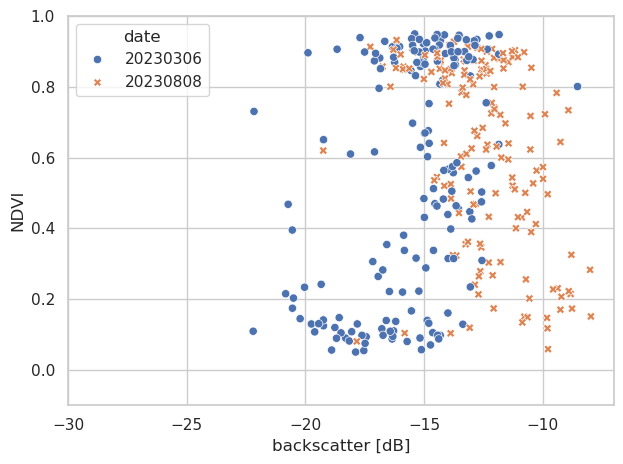

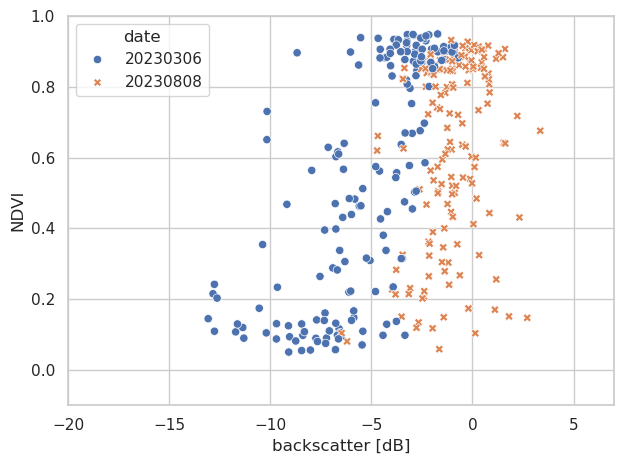

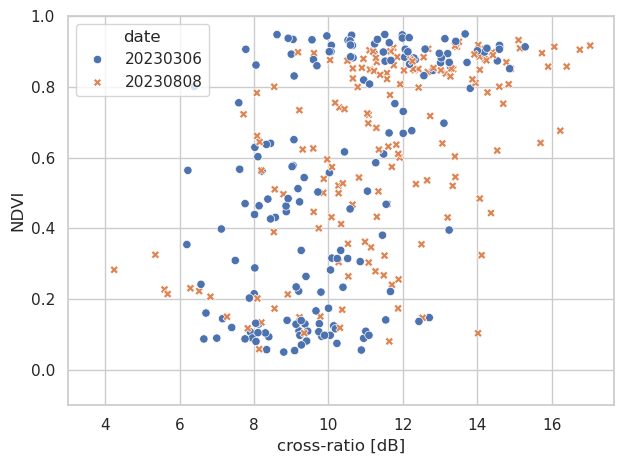

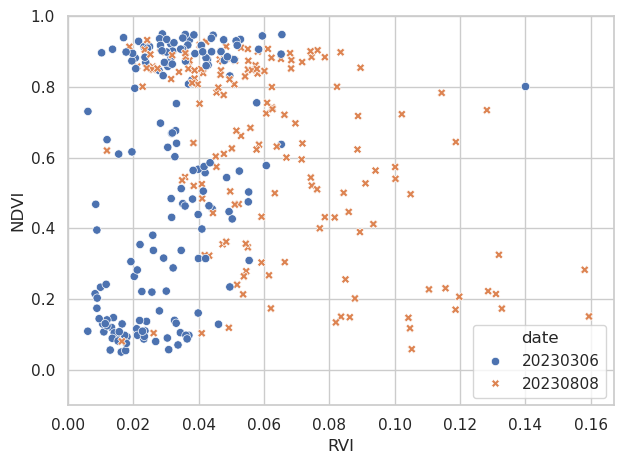

In [70]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    scatterplot_nice(x="median_novasar", y="median_s2", data=joined_pol, 
                     hue="date_s2", style="date_s2", 
                     xlabel=xlabel, ylabel="NDVI", huelabel="date",
                     xlim=xlim,
                     ylim=ylim,
                    )
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colordate.pdf")
    plt.show()

## Sentinel-1

In [71]:
sensor = "S1"

In [72]:
print("S1:", list(sorted(stats_s1.date.unique())))
print("S2:", list(sorted(stats_s2_df.date.unique())))

S1: ['20230305', '20230306', '20230808', '20230809']
S2: ['20230306', '20230808']


In [73]:
_s2_date_of_s1_img = stats_s1.loc[:, "date"].map(lambda d: s1_s2_date_mapping[d]).copy()
stats_s1.loc[:, "s2_date"] = _s2_date_of_s1_img

In [74]:
joined_s1 = stats_s1.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_s1', '_s2'))
joined_s1 = joined_s1[~pd.isnull(joined_s1.date_s2)]
joined_s1 = joined_s1[~pd.isnull(joined_s1.count_s1)]
joined_s1

,mean_s1,median_s1,count_s1,polygon_id,filename_s1,polarization,local_incidence_angle,date_s1,s2_date,mean_s2,median_s2,count_s2,filename_s2,mndwi_mean,date_s2,geometry,area_ha
0,-8.705670,-8.734585,145,0,Subset_S1A_IW_GRDH_1SDV_20230306T111144_202303...,VV,40.726341,20230306,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
1,-19.121775,-18.786608,145,0,Subset_S1A_IW_GRDH_1SDV_20230306T111144_202303...,VH,40.726341,20230306,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,-8.438105,7.029676,88,207,Subset_S1A_IW_GRDH_1SDV_20230808T224604_202308...,CR,39.983700,20230808,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021
3291,-7.823482,4.646389,87,207,Subset_S1A_IW_GRDH_1SDV_20230809T111151_202308...,CR,41.290089,20230809,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021


In [75]:
joined_s1["s2_date_iso"] = joined_s1.s2_date.map(lambda s: s[:4]+"-"+s[4:6]+"-"+s[6:])

In [76]:
joined_s1.to_csv(fig_out_dir / "sentinel1-s2-statistics.csv")

In [77]:
_joined = joined_s1.copy()

datanames = ["VV", "VH", "CR", "RVI"]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]
xlims = [(-20, -2), (-30, -10), None, (0, None)]

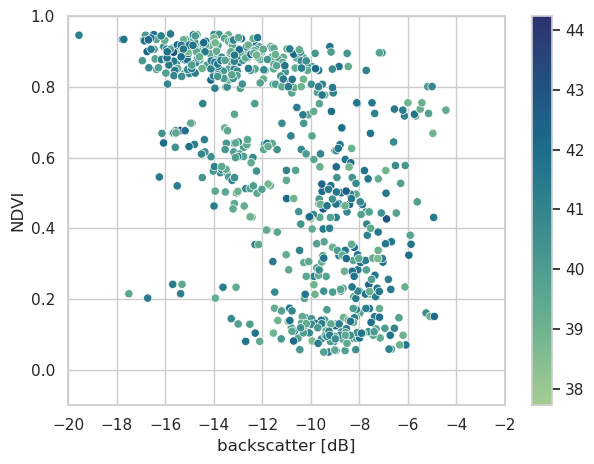

Filtered water pixels away


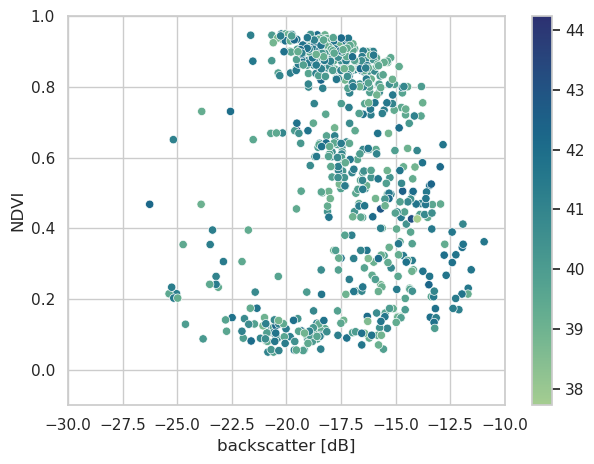

Filtered water pixels away
High p value! 0.704


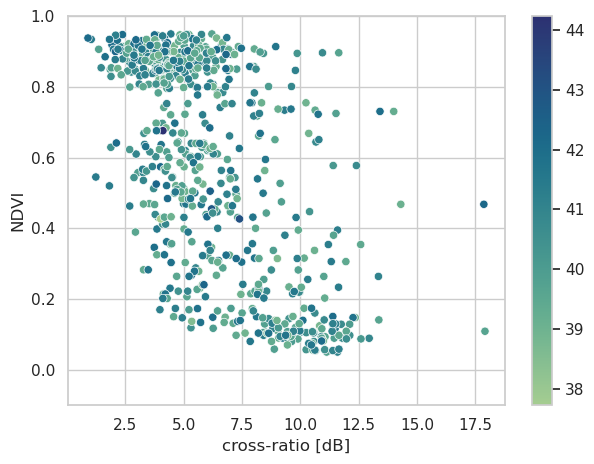

Filtered water pixels away


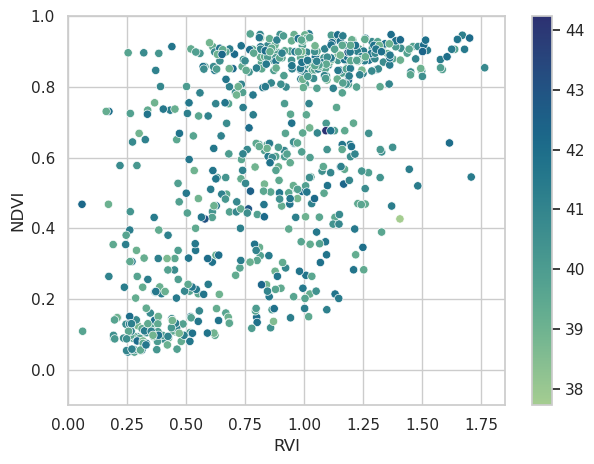

Filtered water pixels away


In [78]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    joined_pol = joined_pol.rename(columns={"s2_date_iso": "date", "local_incidence_angle": "local incidence angle"})
    scatterplot_nice(x="median_s1", y="median_s2", hue="local incidence angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel=None,
                     xlim=xlim,
                     ylim=ylim,
                    )
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_s1", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

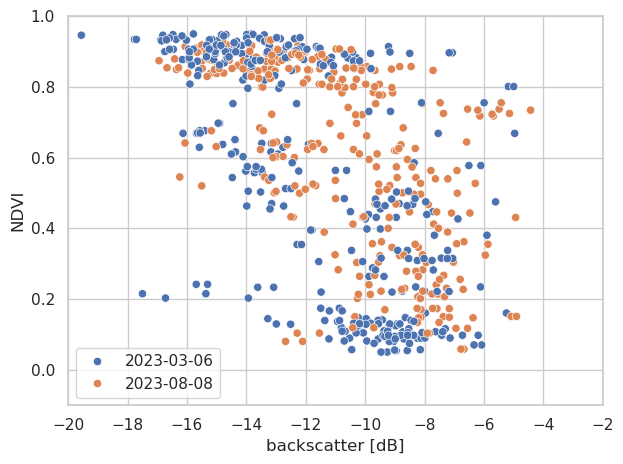

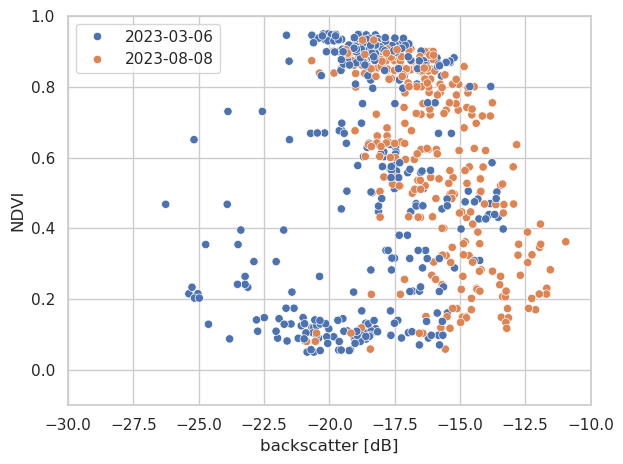

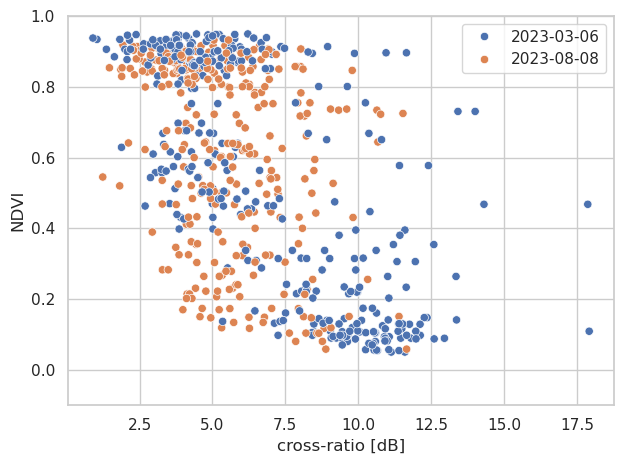

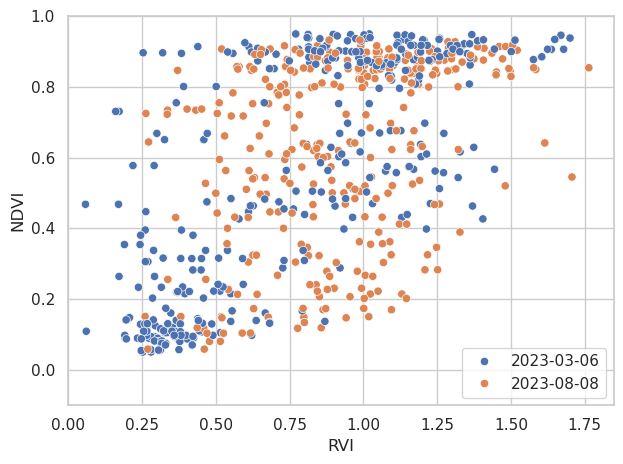

In [79]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname].copy()
    joined_pol = joined_pol.rename(columns={"s2_date_iso": "date", "local_incidence_angle": "local incidence angle"})
    scatterplot_nice(x="median_s1", y="median_s2", hue="date", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel=None,
                     xlim=xlim,
                     ylim=ylim,
                     )
    plt.savefig(fig_out_dir / f"{sensor}-{dataname.lower()}-ndvi-s2-colordate.pdf")
    plt.show()

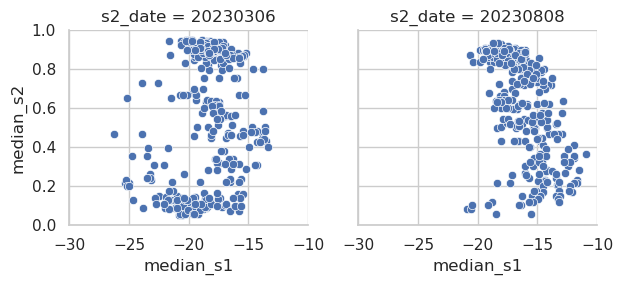

In [80]:
pol = "VH"
data_pol = _joined[_joined.polarization == pol]
sns.relplot(data=data_pol, x="median_s1", y="median_s2", col="s2_date", kind="scatter", col_wrap=4, height=3, facet_kws={"xlim": (-30, -10), "ylim": (0, 1)})

In [81]:
_joined = joined_s1.copy()
ndvi_threshold = 0.25

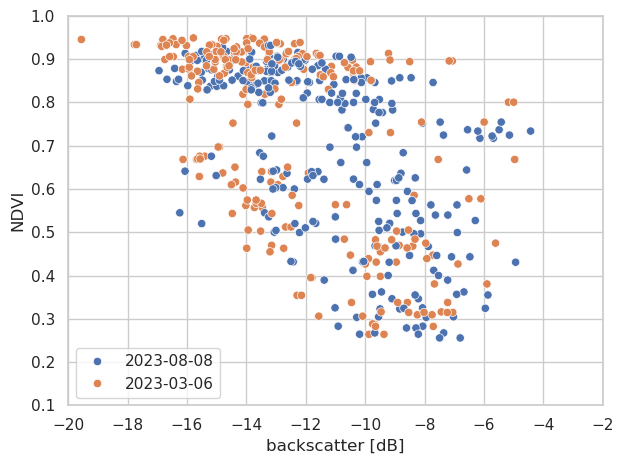

Filtered water pixels away


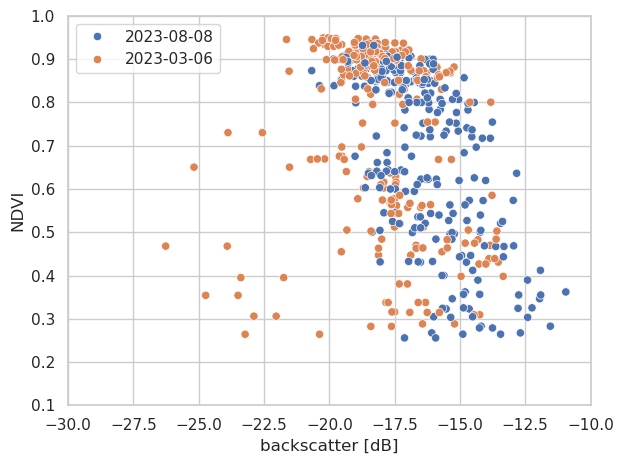

Filtered water pixels away


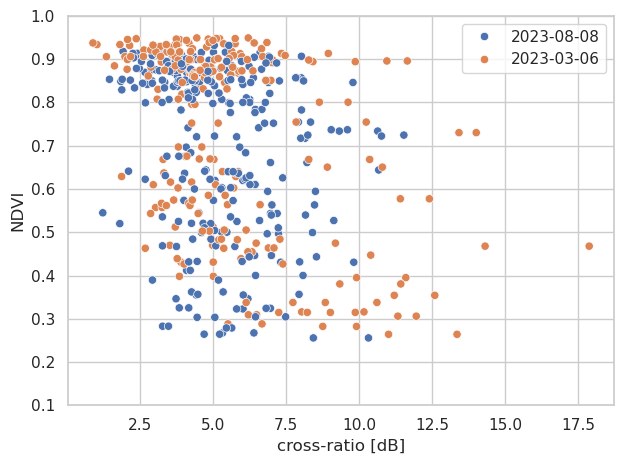

Filtered water pixels away


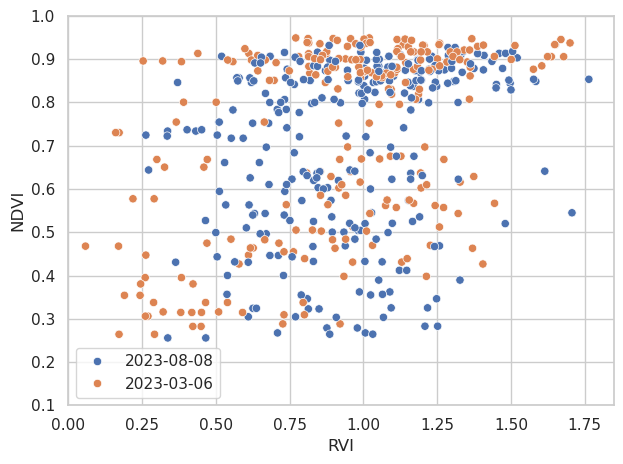

Filtered water pixels away


In [82]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):

    joined_pol = _joined[_joined.polarization == dataname].copy()
    joined_pol = joined_pol[joined_pol.median_s2 > ndvi_threshold]
    joined_pol = joined_pol.rename(columns={"s2_date_iso": "date", "local_incidence_angle": "local incidence angle"})
    scatterplot_nice(x="median_s1", y="median_s2", hue="date", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel=None,
                     xlim=xlim,
                     )
    plt.show()
    dataname += f" NDVI>{ndvi_threshold}"

    pearsonsr_pol = get_filtered_pearsons_r(x="median_s1", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

## SAOCOM

In [83]:
sensor = "SAOCOM"

In [84]:
print("SAO:", stats_saocom.date.unique())
print("S2 :", stats_s2_df.date.unique())

SAO: ['20230306' '20230805' '20230303']
S2 : ['20230808' '20230306']


In [85]:
saocom_s2_date_mapping = {
    # saocom  : s2_date
    "20230303": "20230306", 
    "20230306": "20230306",
    "20230805": "20230808",
}

In [86]:
_s2_date_of_saocom_img = stats_saocom.loc[:, "date"].map(lambda d: saocom_s2_date_mapping[d]).copy()
stats_saocom.loc[:, "s2_date"] = _s2_date_of_saocom_img

In [87]:
joined_saocom = stats_saocom.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_saocom', '_s2'))
joined_saocom = joined_saocom[~pd.isna(joined_saocom.median_s2)]
joined_saocom = joined_saocom[~pd.isna(joined_saocom.mean_saocom)]
joined_saocom

,mean_saocom,median_saocom,count_saocom,polygon_id,filename_saocom,polarization,local_incidence_angle,date_saocom,s2_date,mean_s2,median_s2,count_s2,filename_s2,mndwi_mean,date_s2,geometry,area_ha
0,-14.068604,-14.351557,151,0,Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_202303...,HH,30.512367,20230306,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
1,-26.903839,-26.838278,151,0,Subset_S1A_OPER_SAR_EOSSP__CORE_L1A_OLF_202303...,HV,30.512367,20230306,20230306,0.110613,0.107388,141.0,S2B_MSIL2A_20230306T031619_N0509_R118_T48PWS_2...,-0.256793,20230306,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,0.216643,0.183869,93,207,Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_202308...,RVI,30.347798,20230805,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021
2471,-5.852435,12.911021,93,207,Subset_S1B_OPER_SAR_EOSSP__CORE_L1A_OLF_202308...,CR,30.347798,20230805,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021


In [88]:
joined_saocom.to_csv(fig_out_dir / "saocom-s2-statistics.csv")

In [89]:
_joined = joined_saocom.copy()

datanames = ["HH", "HV", "CR", "RVI"]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]
xlims = [(-22.5, -2.5), (-42, -10.5), None, None]

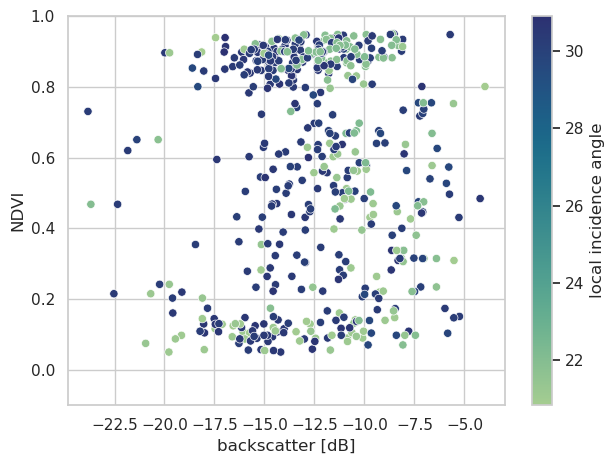

Filtered water pixels away
High p value! 0.931


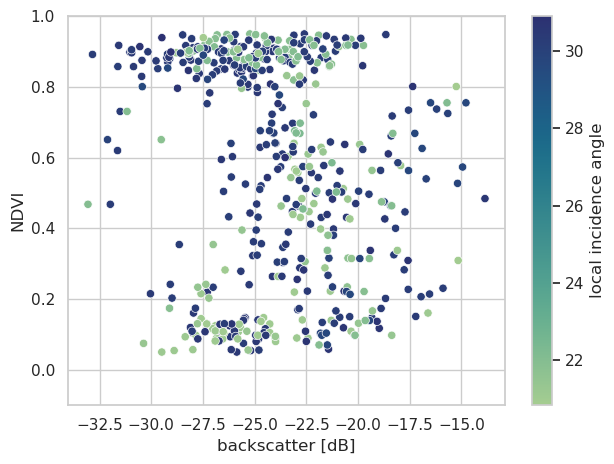

Filtered water pixels away


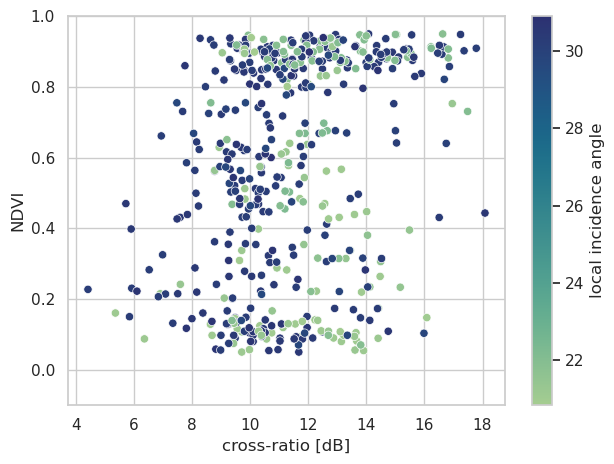

Filtered water pixels away


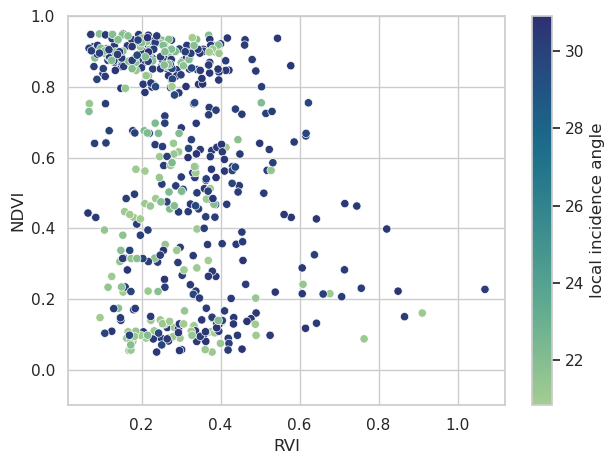

Filtered water pixels away


In [90]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_saocom", y="median_s2", hue="local_incidence_angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="local incidence angle",
                     ylim=ylim,
                     )
    plt.savefig(fig_out_dir / f"{sensor.lower()}-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_saocom", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

## CSG visualization

In [91]:
sensor = "CSG"

In [92]:
print("CSG:", stats_csg.date.unique())
print("S2 :", stats_s2_df.date.unique())

CSG: ['20230806']
S2 : ['20230808' '20230306']


In [93]:
csg_s2_date_mapping = {
    # csg_date : s2_date
    "20230806": "20230808",
}

_s2_date_of_csg_img = stats_csg.loc[:, "date"].map(lambda d: csg_s2_date_mapping[d]).copy()
stats_csg.loc[:, "s2_date"] = _s2_date_of_csg_img

In [94]:
joined_csg = stats_csg.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_csg', '_s2'))
joined_csg = joined_csg[~pd.isnull(joined_csg.count_csg)]
joined_csg

,mean_csg,median_csg,count_csg,polygon_id,filename_csg,polarization,local_incidence_angle,date_csg,s2_date,mean_s2,median_s2,count_s2,filename_s2,mndwi_mean,date_s2,geometry,area_ha
1,-10.209681,-10.204177,996.0,0,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,HH,44.928320,20230806,20230808,0.790918,0.784024,141.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.541031,20230808,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
2,-17.502167,-17.504879,996.0,0,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,HV,44.928320,20230806,20230808,0.790918,0.784024,141.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.541031,20230808,"POLYGON ((105.69147 10.5059, 105.69139 10.5035...",1.405816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,1.258777,1.171140,602.0,207,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,RVI,45.464109,20230806,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021
962,-11.748912,3.695570,602.0,207,Subset_CSG_SSAR2_DGM_B_0101_STR_014_HH-HV-LIA_...,CR,45.464109,20230806,20230808,0.172644,0.173638,39.0,S2A_MSIL2A_20230808T031541_N0509_R118_T48PWS_2...,-0.581453,20230808,"POLYGON ((105.74256 10.68712, 105.74199 10.685...",0.844021


In [95]:
joined_csg.to_csv(fig_out_dir / "csk-s2-statistics.csv")

In [96]:
_joined = joined_csg.copy()

datanames = ["HH", "HV", "CR", "RVI"]
xlabels = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]
xlims = [(-16, -3), (-22, -12), (2, None), (0.2, None)]

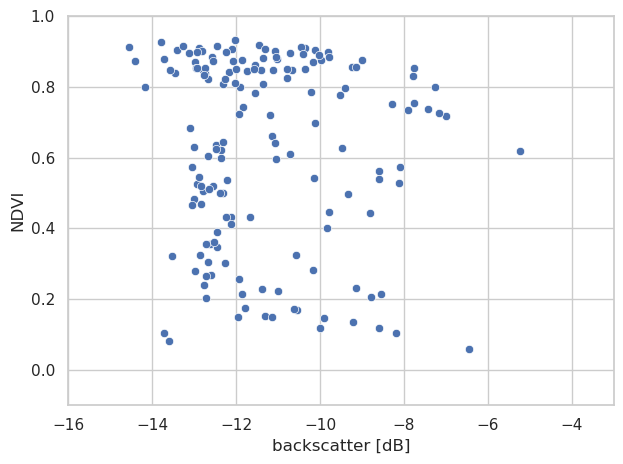

Filtered water pixels away
High p value! 0.926


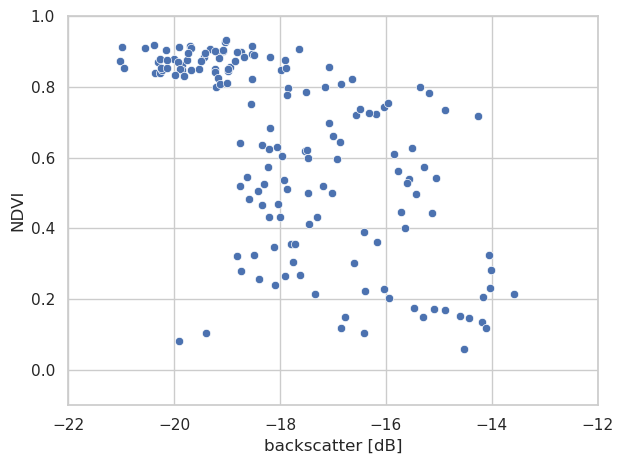

Filtered water pixels away


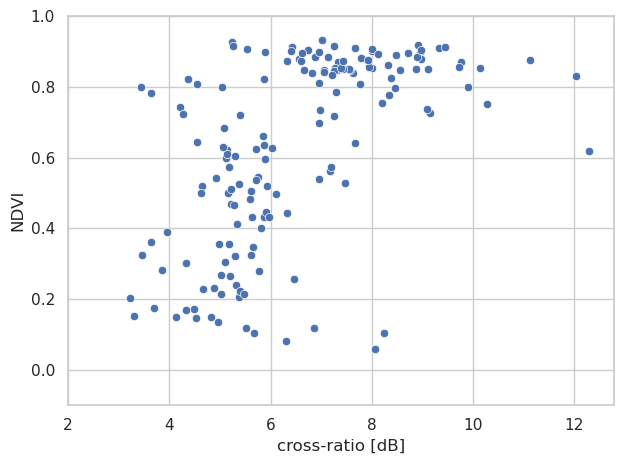

Filtered water pixels away


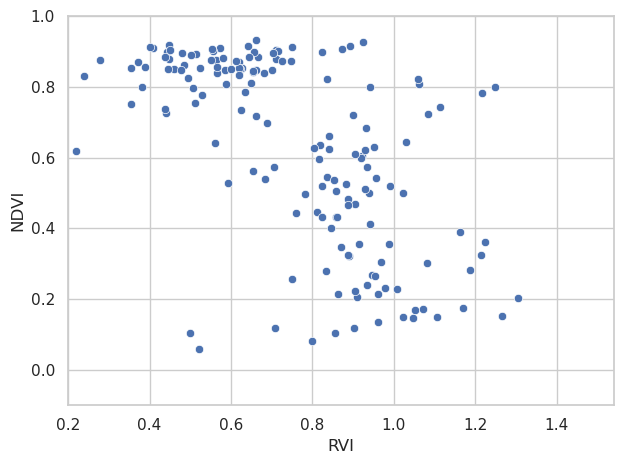

Filtered water pixels away


In [97]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_csg", y="median_s2", hue=None,
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel=None,
                     ylim=ylim, xlim=xlim,
                    )
    plt.savefig(fig_out_dir / f"{sensor.lower()}-{dataname.lower()}-ndvi-s2.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_csg", y="median_s2", data=joined_pol)
    pearsonsr.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

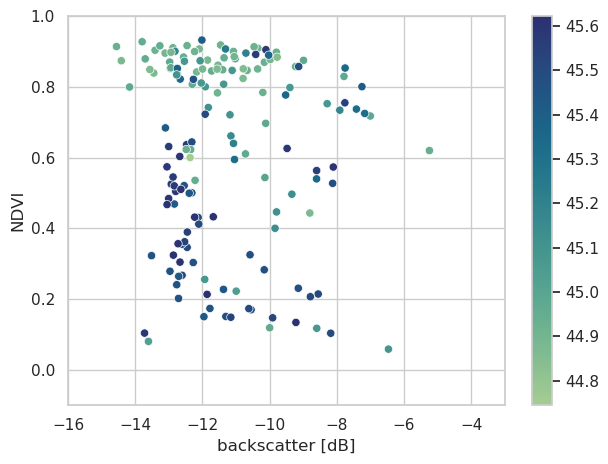

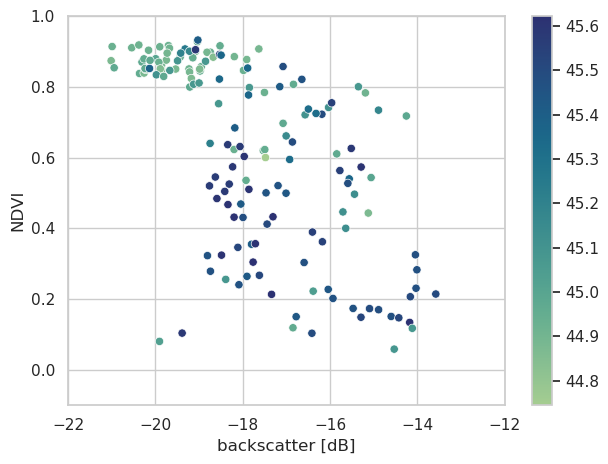

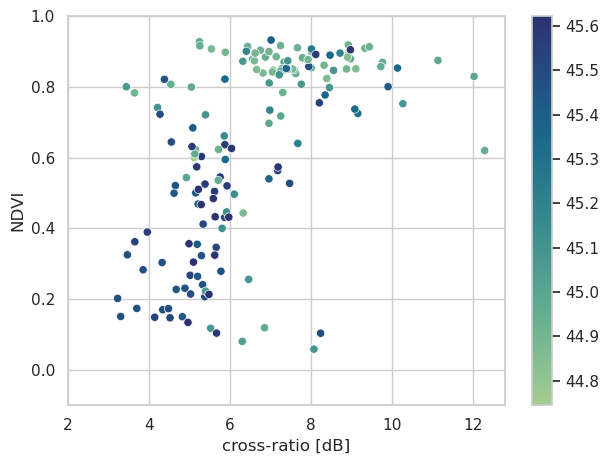

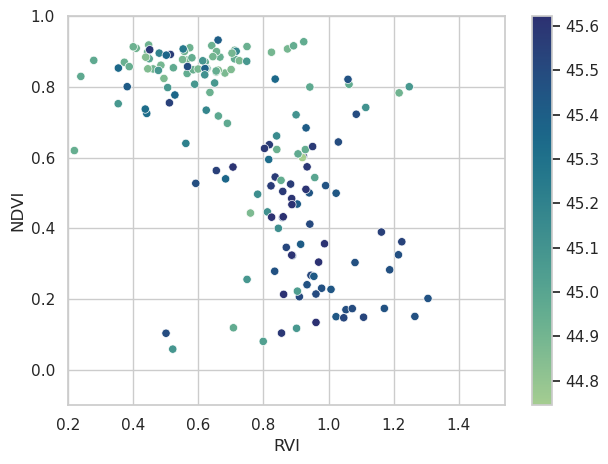

In [98]:
for dataname, xlabel, xlim in zip(datanames, xlabels, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    joined_pol = joined_pol.rename(columns={"s2_date_iso": "date", "local_incidence_angle": "local incidence angle"})

    scatterplot_nice(x="median_csg", y="median_s2", hue="local incidence angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel=None,
                     xlim=xlim,
                     ylim=ylim,
                     )
    plt.savefig(fig_out_dir / f"{sensor.lower()}-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()

# Pearson's r Tabelle

In [99]:
pearsonsr_df = pd.DataFrame(pearsonsr)
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].to_markdown())
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].style.format({"r": '{:.2f}', "p": "{:.3f}"},).to_latex(hrules=True))

|    | sensor   | polarization   |   N |           r |           p |
|---:|:---------|:---------------|----:|------------:|------------:|
|  0 | NovaSAR  | HV             | 313 |  0.14775    | 0.00884768  |
|  1 | NovaSAR  | HH             | 313 |  0.509642   | 4.30322e-22 |
|  2 | NovaSAR  | CR             | 313 |  0.514422   | 1.5198e-22  |
|  3 | NovaSAR  | RVI            | 313 |  0.0129015  | 0.820154    |
|  4 | NovaSAR  | HV NDVI<0.25   |  71 |  0.339153   | 0.00381202  |
|  5 | NovaSAR  | HH NDVI<0.25   |  71 |  0.325989   | 0.00553209  |
|  6 | NovaSAR  | CR NDVI<0.25   |  71 |  0.00342371 | 0.977394    |
|  7 | NovaSAR  | RVI NDVI<0.25  |  71 |  0.379999   | 0.00108067  |
|  8 | NovaSAR  | HV NDVI>0.25   | 242 | -0.195087   | 0.00230012  |
|  9 | NovaSAR  | HH NDVI>0.25   | 242 |  0.271766   | 1.81308e-05 |
| 10 | NovaSAR  | CR NDVI>0.25   | 242 |  0.38111    | 8.73649e-10 |
| 11 | NovaSAR  | RVI NDVI>0.25  | 242 | -0.194104   | 0.00242285  |
| 12 | S1       | VV             |